## 1. Load data from DBPedia

In [1]:
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data  = pd.read_csv("data/DBPEDIA_test.csv")

In [3]:
data = data[(data.l1 == "Agent") &(data.l2.isin(["Athlete", "Politician", "Artist", "Actor"]))].reset_index(drop=True)

In [4]:
data = data[["text","l2"]]

In [5]:
data_ath, _ = train_test_split(data[data.l2 == "Athlete"],train_size=250, random_state=561)
data_pol, _ = train_test_split(data[data.l2 == "Politician"],train_size=250, random_state=561)
data_art, _ = train_test_split(data[data.l2 == "Artist"],train_size=250, random_state=561)
data_act, _ = train_test_split(data[data.l2 == "Actor"],train_size=250, random_state=561)

In [6]:
data_raw = pd.concat([data_ath, data_pol, data_art, data_act]).reset_index(drop=True).rename(columns = {"l2":"label"})

In [7]:
data_raw

,text,label
0,Matthew John King (born 25 February 1994) is a...,Athlete
1,"Carlton A. Roles (August 29, 1903 – January 16...",Athlete
2,James Thiessen (born 10 February 1974) is a fo...,Athlete
3,Alan Thomas Woodman (7 June 1955 – 8 May 2014)...,Athlete
4,"David McKinley Henderson (born July 21, 1964) ...",Athlete
...,...,...
995,"Aya Sugimoto (杉本 彩 Sugimoto Aya, born July 19,...",Actor
996,"Misty Rain (born August 10, 1969 in Long Beach...",Actor
997,"Holly Anne Hallstrom (born August 24, 1952) wa...",Actor
998,"Aya Ishizu (石津 彩 Ishizu Aya, born February 22,...",Actor


## 2. Baseline model - NMF, LSA and LDA model
### 2.1. Data Preparation

In [731]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy 
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Nmf, LsiModel
from gensim.models.coherencemodel import CoherenceModel
from copy import deepcopy

In [727]:
data = load_flat_dataset("data/dbpedia_clean.csv")

In [728]:
nlp = spacy.load('en_core_web_sm')

In [729]:
docs = [nlp(" ".join(i)) for i in data]

In [730]:
texts, article = [], []
for doc in docs:
    for word in doc:

        if not word.is_stop and not word.is_punct and not word.like_num and word.text != 'I':
            article.append(word.lemma_)


    texts.append(article)
    article = []

In [564]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### 2.2. Find the best k

In [400]:
k_ls = range(1,21,1)
co_lda = []
co_lsa = []
co_nmf = []
for k in k_ls:
    
    lda_model = LdaModel(corpus = corpus, num_topics = k, id2word = dictionary, random_state = 561, iterations=1000, chunksize=50)
    cm = CoherenceModel(model = lda_model, texts=texts, dictionary=dictionary, coherence = 'c_v').get_coherence()
    co_lda.append(cm)
    
    nmf_model = Nmf(corpus = corpus, num_topics=k, id2word=dictionary, random_state=561, w_max_iter=1000, chunksize=50)
    cm = CoherenceModel(model = nmf_model, texts=texts, dictionary=dictionary, coherence = 'c_v').get_coherence()
    co_nmf.append(cm)
    
    lsa_model = LsiModel(corpus = corpus, num_topics = k, id2word = dictionary, power_iters=3, chunksize=50)
    cm = CoherenceModel(model = lsa_model, texts=texts, dictionary=dictionary, coherence = 'c_v').get_coherence()
    co_lsa.append(cm)

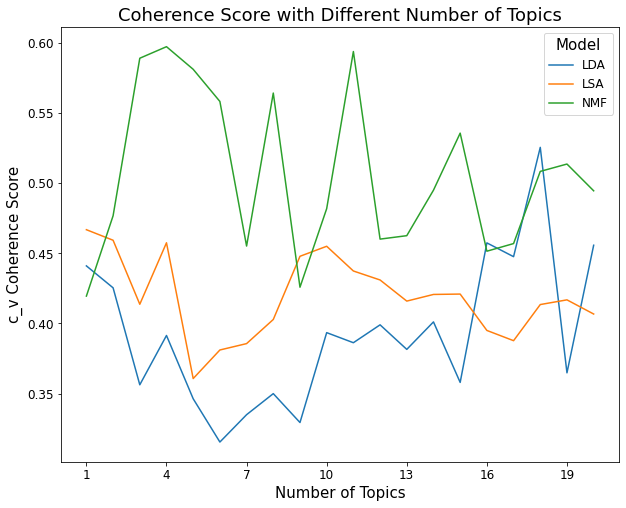

In [413]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(k_ls, co_lda, label = "LDA")
ax.plot(k_ls, co_lsa, label = "LSA")
ax.plot(k_ls, co_nmf, label = "NMF")
plt.xticks(ticks = range(1,21,3), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of Topics", fontsize=15)
plt.ylabel("c_v Coherence Score", fontsize=15)
plt.title("Coherence Score with Different Number of Topics", fontsize=18)
plt.legend(title = "Model", title_fontsize=15, fontsize=12)
plt.savefig("visualization/coherence_score.png",dpi=300)
plt.show()

### 2.3. Model with best k

In [565]:
lda_best = LdaModel(corpus = corpus, num_topics = 4, id2word = dictionary, random_state = 561, iterations=1000, chunksize=50)

nmf_best = Nmf(corpus = corpus, num_topics = 4, id2word=dictionary, random_state=561, w_max_iter=1000, chunksize=50)

lsa_best = LsiModel(corpus = corpus, num_topics = 4, id2word = dictionary, power_iters=3, chunksize=50)

In [635]:
def extract_topic(fun, corpus):
    
    topic_list = []
    
    for c in corpus:
        temp = pd.DataFrame(fun[c])
        highest = temp.iloc[:,1].argmax()
        topic_list.append(temp.iloc[highest,0])

    return topic_list

In [568]:
lda_topic = extract_topic(lda_best, corpus)

In [569]:
lsa_topic = extract_topic(lsa_best, corpus)

In [570]:
nmf_topic = extract_topic(nmf_best, corpus)

### 2.4. Compare results with Actual subtopics

In [571]:
docs = [str(doc) for doc in docs]

In [572]:
vocab_size = len(set(" ".join(docs).split(" ")))

In [573]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (1000, 1375))

In [574]:
from sklearn.manifold import TSNE

In [575]:
tsne = TSNE(random_state=561)

In [576]:
X_tsne = tsne.fit_transform(X_bow)

In [577]:
label_map = {"Athlete":0, "Politician":1, "Artist":2, "Actor":3}

<ipython-input-578-4f7c8a643580>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(-40,21,10),fontsize=12)
<ipython-input-578-4f7c8a643580>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(-40,31,10), fontsize=12)


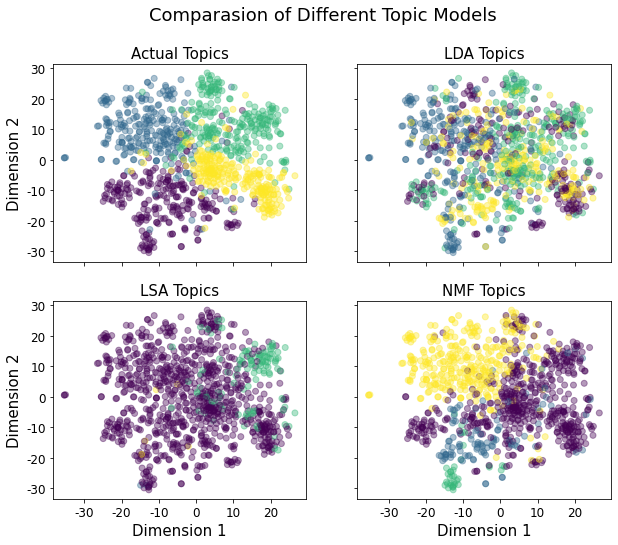

In [578]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
s1 = axs[0,0].scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.4)
axs[0,0].set_title('Actual Topics', fontsize=15)
s2 = axs[0,1].scatter(X_tsne[:,0],X_tsne[:,1], c = lda_topic, alpha=0.4)
axs[0,1].set_title('LDA Topics', fontsize=15)
s3 = axs[1,0].scatter(X_tsne[:,0],X_tsne[:,1], c = lsa_topic, alpha=0.4)
axs[1,0].set_title('LSA Topics', fontsize=15)
s4 = axs[1,1].scatter(X_tsne[:,0],X_tsne[:,1], c = nmf_topic, alpha=0.4)
axs[1,1].set_title('NMF Topics', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel(xlabel='Dimension 1', fontsize=15)
    ax.set_ylabel(ylabel='Dimension 2', fontsize=15)
    ax.set_xticklabels(range(-40,21,10),fontsize=12)
    ax.set_yticklabels(range(-40,31,10), fontsize=12)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Comparasion of Different Topic Models", fontsize=18)
#fig.legend(s1.legend_elements()[0],s2.legend_elements()[1], loc="center right", title="Topics", title_fontsize=15, fontsize=12)
plt.savefig("visualization/scatter_basic.png", dpi=300)
plt.show()

### Add in bigrams and trigrams

In [819]:
def n_gram(n, texts, min_count=5):
    n_gram = deepcopy(texts)
    for i in range(n-1):
        freeze = gensim.models.phrases.Phrases(n_gram, delimiter="$", min_count=min_count, 
                                               connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
        n_gram = [freeze[line] for line in n_gram]
    
    return n_gram

In [789]:
def n_gram_all(n, texts):
    n_gram = deepcopy(texts)
    
    for i, doc in enumerate(n_gram):
        
        for j in range(0, len(doc)-n+1):
            n_gram[i].append('$'.join(doc[j:j+n]))
    
    return n_gram

In [820]:
tri_gram = n_gram(3,texts)

In [821]:
len(tri_gram)

1000

In [822]:
dictionary_tri = Dictionary(tri_gram)
corpus_tri = [dictionary_tri.doc2bow(text) for text in tri_gram]

In [790]:
tri_gram_all = n_gram_all(3, texts)

In [792]:
dictionary_tri = Dictionary(tri_gram_all)
corpus_tri = [dictionary_tri.doc2bow(text) for text in tri_gram_all]

### 2.3. Model with best k

In [823]:
lda_best_tri = LdaModel(corpus = corpus_tri, num_topics = 4, id2word = dictionary_tri, random_state = 561, iterations=1000, chunksize=50)

nmf_best_tri = Nmf(corpus = corpus_tri, num_topics = 4, id2word=dictionary_tri, random_state=561, w_max_iter=1000, chunksize=50)

lsa_best_tri = LsiModel(corpus = corpus_tri, num_topics = 4, id2word = dictionary_tri, power_iters=3, chunksize=50)

In [824]:
lda_topic_tri = extract_topic(lda_best_tri, corpus_tri)

In [825]:
lsa_topic_tri = extract_topic(lsa_best_tri, corpus_tri)

In [826]:
nmf_topic_tri = extract_topic(nmf_best_tri, corpus_tri)

### 2.4. Compare results with Actual subtopics

<ipython-input-827-e9852a47d366>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(-40,21,10),fontsize=12)
<ipython-input-827-e9852a47d366>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(-40,31,10), fontsize=12)


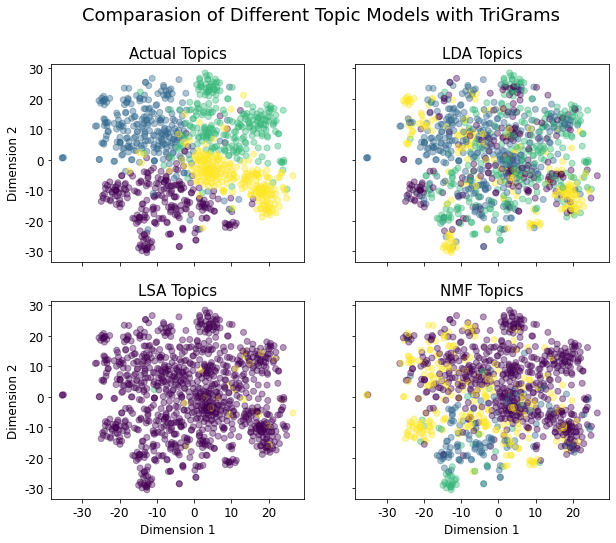

In [827]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
s1 = axs[0,0].scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.4)
axs[0,0].set_title('Actual Topics', fontsize=15)
s2 = axs[0,1].scatter(X_tsne[:,0],X_tsne[:,1], c = lda_topic_tri, alpha=0.4)
axs[0,1].set_title('LDA Topics', fontsize=15)
s3 = axs[1,0].scatter(X_tsne[:,0],X_tsne[:,1], c = lsa_topic_tri, alpha=0.4)
axs[1,0].set_title('LSA Topics', fontsize=15)
s4 = axs[1,1].scatter(X_tsne[:,0],X_tsne[:,1], c = nmf_topic_tri, alpha=0.4)
axs[1,1].set_title('NMF Topics', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel(xlabel='Dimension 1', fontsize=12)
    ax.set_ylabel(ylabel='Dimension 2', fontsize=12)
    ax.set_xticklabels(range(-40,21,10),fontsize=12)
    ax.set_yticklabels(range(-40,31,10), fontsize=12)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Comparasion of Different Topic Models with TriGrams", fontsize=18)
#fig.legend(s1.legend_elements()[0],s2.legend_elements()[1], loc="center right", title="Topics", title_fontsize=15, fontsize=12)
plt.savefig("visualization/scatter_n_grams.png", dpi=300)
plt.show()

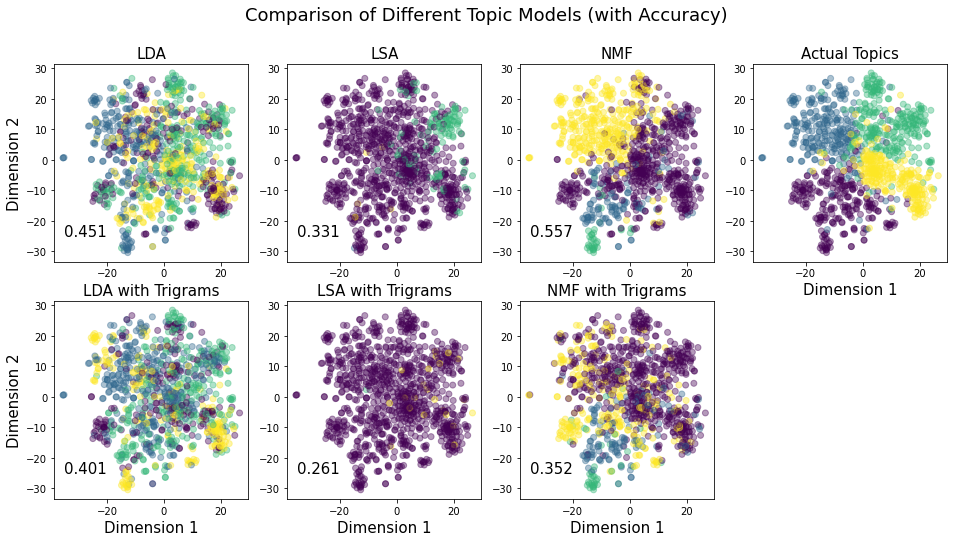

In [881]:
plt.figure(figsize=(16,8))

plt.subplot(2, 4, 1)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = lda_topic, alpha=0.4)
plt.text(-35,-25,"0.451", fontsize=15)
plt.title('LDA', fontsize=15)
plt.ylabel("Dimension 2", fontsize=15)


plt.subplot(2, 4, 2)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = lsa_topic, alpha=0.4)
plt.text(-35,-25,"0.331", fontsize=15)
plt.title('LSA', fontsize=15)


plt.subplot(2, 4, 3)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = nmf_topic, alpha=0.4)
plt.text(-35,-25,"0.557", fontsize=15)
plt.title('NMF', fontsize=15)


plt.subplot(2, 4, 4)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.4)
plt.title('Actual Topics', fontsize=15)
plt.xlabel("Dimension 1", fontsize = 15)


plt.subplot(2, 4, 5)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = lda_topic_tri, alpha=0.4)
plt.text(-35,-25,"0.401", fontsize=15)
plt.title('LDA with Trigrams', fontsize=15)
plt.xlabel("Dimension 1", fontsize = 15)
plt.ylabel("Dimension 2", fontsize=15)

plt.subplot(2, 4, 6)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = lsa_topic_tri, alpha=0.4)
plt.text(-35,-25,"0.261", fontsize=15)
plt.title('LSA with Trigrams', fontsize=15)
plt.xlabel("Dimension 1", fontsize = 15)


plt.subplot(2, 4, 7)
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = nmf_topic_tri, alpha=0.4)
plt.text(-35,-25,"0.352", fontsize=15)
plt.title('NMF with Trigrams', fontsize=15)
plt.xlabel("Dimension 1", fontsize = 15)


plt.suptitle("Comparison of Different Topic Models (with Accuracy)", fontsize=18)
#fig.legend(s1.legend_elements()[0],s2.legend_elements()[1], loc="center right", title="Topics", title_fontsize=15, fontsize=12)
plt.savefig("visualization/scatter_compare.png", dpi=300)
plt.show()

## NLDA model
### Data Preparation

In [8]:
from settings.common import get_pp_pipeline, load_flat_dataset, save_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
from preprocessing_pipeline.NextGen import NextGen
from settings.common import load_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
import csv
import matplotlib.pyplot as plt
import gensim

In [9]:
pp = get_pp_pipeline(remove_stopwords=True, stem=False, clean_twitter=False, lemmatize=True)

In [10]:
raw_data = pd.DataFrame(data_raw.text)

In [11]:
raw_data.to_csv("data/dbpedia_raw.csv", header=False, index=False)

In [12]:
dataset = load_flat_dataset("data/dbpedia_raw.csv", delimiter=' ')

In [13]:
clean_ds = []
for data in dataset:
    tokens = gensim.utils.simple_preprocess(" ".join(data))
    clean_ds.append(tokens)

In [15]:
save_flat_dataset("data/dbpedia_clean.csv", clean_ds, delimiter=' ')

In [16]:
dataset = []
from src.gdtm.helpers.common import load_flat_dataset
from src.gdtm.models import GTM, NLDA

tnd_path = 'topic-noise-models-source/mallet-tnd/bin/mallet'
lda_path = 'topic-noise-models-source/mallet-lda/bin/mallet'
gtm_path = 'topic-noise-models-source/mallet-gtm/bin/mallet'
dataset = load_flat_dataset("dbpedia_clean.csv")

In [17]:
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [18]:
len(dataset)

2000

### Get the NLDA topics and noise

In [19]:
model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=20, lda_k=20, tnd_beta1=16, phi=10, top_words=30)

In [20]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('of$the', 1300), ('born', 1259), ('in$the', 736), ('american', 575), ('he$was', 551), ('from$to', 400), ('to$the', 374), ('member', 366), ('served', 359), ('played', 354), ('actress', 344), ('at$the', 308), ('team', 285), ('pornographic', 247), ('actor', 242), ('party', 240), ('politician', 238), ('is$an', 218), ('member$of', 216), ('an$american', 212), ('for$the', 195), ('served$as', 190), ('won', 179), ('was$an', 173), ('elected', 167), ('in$he', 163), ('and$the', 151), ('japanese', 145), ('national', 138), ('in$and', 138), ('he$is', 136), ('governor', 135), ('time', 134), ('player', 133), ('was$the', 130), ('february', 128), ('career', 127), ('august', 126), ('september', 125), ('world', 125), ('state', 124), ('united$states', 123), ('june', 122), ('october', 120), ('january', 119), ('united', 115), ('on$the', 114), ('work', 114), ('professional', 113), ('march', 111), ('university', 111), ('april', 109), ('during$the', 108), ('december', 108), ('one$of', 106), ('comic', 10

In [21]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [22]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [23]:
print(clean_topic)

[['election', 'mayor', 'canadian', 'general', 'appointed', 'council', 'john', 'parliament', 'minister', 'house', 'south', 'term', 'county', 'conservative', 'deputy', 'north', 'local', 'held', 'federal', 'secretary', 'norwegian', 'lawyer', 'leader', 'labour', 'previously', 'assembly'], ['worked', 'york', 'award', 'fashion', 'art', 'including', 'early', 'designer', 'works', 'show', 'family', 'moved', 'business', 'city', 'radio', 'comedy', 'public', 'based', 'made', 'style', 'academy', 'chinese', 'began', 'london', 'white', 'gallery', 'studied', 'received', 'young', 'design'], ['known$for', 'for$his', 'best$known', 'comic$book', 'he$has', 'known$as', 'has$been', 'as$well', 'is$also', 'such$as', 'his$work', 'well$as', 'american$comic', 'has$also', 'and$has', 'born$october', 'is$best', 'also$known', 'october$is', 'hall$of', 'born$is', 'fashion$designer', 'who$has', 'stand$up', 'writer$and', 'born$july', 'book$artist'], ['is$japanese', 'she$was', 'japanese$voice', 'is$the', 'born$september',

In [24]:
with open("data/dbpedia_NLDA_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

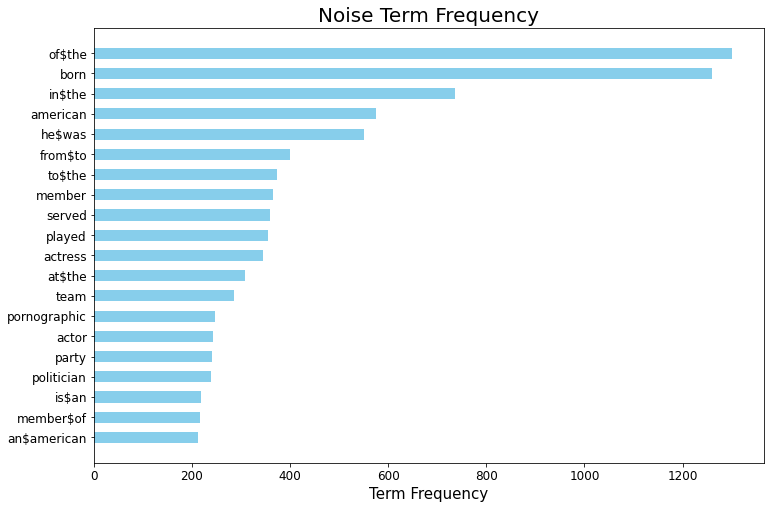

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[30:], noise_data.Noise_Weight[30:], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)

### Guided Topic Modeling (GTM)

In [36]:
len(dataset)

2000

In [37]:
dataset = load_flat_dataset("data/dbpedia_clean.csv")

In [38]:
# add bigrams to the dataset
seed_topics_file = "data/dbpedia_seed_topics.csv"

ngrams = []
with open(seed_topics_file, 'r') as f:
    for line in f:
        topic = line.strip().split(',')
        for w in topic:
            if '$' in w:
                ngrams.append(w)
dataset = insert_ngrams_flat_from_lists(dataset, ngrams, [])
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [39]:
model = GTM(dataset=dataset, mallet_tnd_path=tnd_path, mallet_gtm_path=gtm_path, 
              tnd_k=20, gtm_k=20, tnd_beta1 = 16, over_sampling_factor=100, phi=10,
              top_words=20,tnd_iterations=1000, gtm_iterations=1000, seed_topics_file=seed_topics_file)

In [40]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('in$the', 1178), ('of$the', 853), ('born', 743), ('he$was', 680), ('from$to', 398), ('member', 377), ('to$the', 375), ('actress', 346), ('american', 314), ('member$of', 308), ('at$the', 307), ('played', 301), ('governor', 265), ('politician', 255), ('pornographic', 249), ('elected', 248), ('actor', 239), ('served', 238), ('party', 235), ('is$an', 218), ('an$american', 215), ('player', 212), ('for$the', 192), ('was$an', 177), ('served$as', 175), ('team', 167), ('in$he', 167), ('and$the', 166), ('japanese', 145), ('won', 130), ('was$the', 130), ('august', 127), ('on$the', 122), ('november', 122), ('june', 122), ('world', 118), ('from$the', 117), ('september', 116), ('united', 116), ('work', 113), ('states', 111), ('state', 110), ('april', 109), ('and$was', 108), ('during$the', 108), ('series', 107), ('artist', 106), ('born$in', 103), ('national', 103), ('south', 102), ('president', 102), ('professional', 101), ('school', 101), ('comics', 100), ('is$japanese', 100), ('for$his', 9

In [41]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [42]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [43]:
print(clean_topic)

[['time', 'summer$olympics', 'competed', 'championships', 'european', 'women', 'french', 'record', 'event', 'represented', 'place', 'swimmer', 'champion', 'international', 'events', 'swimming', 'olympic'], ['comics', 'best$known', 'comic$book', 'writer', 'award', 'company', 'manga', 'comic', 'including', 'hall', 'based', 'paul', 'character', 'fame', 'long', 'illustrator'], ['was$born', 'in$and', 'and$he', 'by$the', 'of$his', 'was$also', 'died$in', 'between$and', 'he$became', 'to$be', 'he$died', 'moved$to', 'and$in', 'which$he', 'where$he', 'that$he'], ['july', 'february', 'australian', 'british', 'north', 'debut', 'rugby', 'australia', 'west', 'union', 'made', 'january', 'john', 'cricket', 'international', 'march'], ['president', 'election', 'mayor', 'canadian', 'general', 'appointed', 'council', 'parliament', 'government', 'political', 'canada', 'prime$minister', 'term', 'conservative'], ['was$elected', 'house$of', 'united$states', 'he$served', 'the$united', 'to$he', 'elected$to', 'to

In [44]:
with open("data/dbpedia_GTM_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

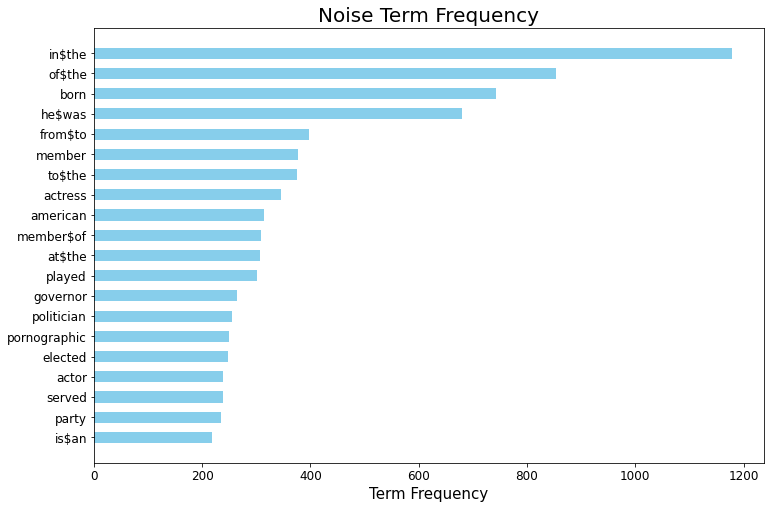

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[30:], noise_data.Noise_Weight[30:], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)

## Mapping topics

In [685]:
data = load_flat_dataset("data/dbpedia_clean.csv")
docs = [" ".join(doc) for doc in data]

In [686]:
data_topic = pd.read_csv("data/dbpedia_mapping_topics.csv")

In [687]:
topic_list = []
for doc in docs: 
    temp = []
    for i in range(data_topic.shape[1]):
        count=0
        topic_word = list(data_topic.iloc[:,i].dropna())
        topic_word = [i.replace('$',' ') for i in topic_word]
        for word in topic_word:
            if word in doc:
                count+=1
        temp.append(count)
    topic_list.append(np.argmax(temp))

<ipython-input-886-a686ada2a22a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(-40,21,10),fontsize=12)
<ipython-input-886-a686ada2a22a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(-40,31,10), fontsize=12)


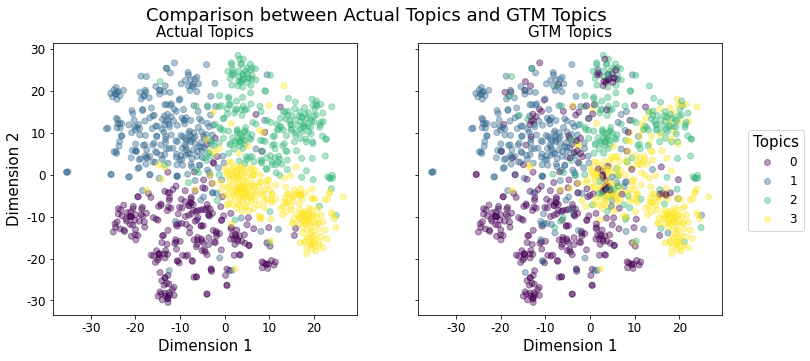

In [886]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
s1 = axs[0].scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.4)
axs[0].set_title('Actual Topics', fontsize=15)
s2 = axs[1].scatter(X_tsne[:,0],X_tsne[:,1], c = topic_list, alpha=0.4)
axs[1].set_title('GTM Topics', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel(xlabel='Dimension 1', fontsize=15)
    ax.set_ylabel(ylabel='Dimension 2', fontsize=15)
    ax.set_xticklabels(range(-40,21,10),fontsize=12)
    ax.set_yticklabels(range(-40,31,10), fontsize=12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Comparison between Actual Topics and GTM Topics", fontsize=18)
fig.legend(s1.legend_elements()[0],s1.legend_elements()[1], loc="center right", title="Topics", title_fontsize=15, fontsize=12)
plt.savefig("visualization/scatter_gtm.png", dpi=300)
plt.show()

In [887]:
accuracy_score(list(data_raw.label.map(label_map)), topic_list)

0.758

In [884]:
confusion_matrix(list(data_raw.label.map(label_map)), topic_list)

array([[225,  16,   6,   3],
       [ 31, 211,   7,   1],
       [ 28,  11, 147,  64],
       [ 36,  12,  27, 175]])

In [885]:
print(classification_report(list(data_raw.label.map(label_map)), topic_list, digits=4))

              precision    recall  f1-score   support

           0     0.7031    0.9000    0.7895       250
           1     0.8440    0.8440    0.8440       250
           2     0.7861    0.5880    0.6728       250
           3     0.7202    0.7000    0.7099       250

    accuracy                         0.7580      1000
   macro avg     0.7633    0.7580    0.7540      1000
weighted avg     0.7633    0.7580    0.7540      1000



In [511]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report

In [828]:
cm_lda_tri = confusion_matrix(list(data_raw.label.map(label_map)), lda_topic_tri)

In [829]:
cm_lda = confusion_matrix(list(data_raw.label.map(label_map)), lda_topic)

In [832]:
cm_lsa = confusion_matrix(list(data_raw.label.map(label_map)), lsa_topic)

In [834]:
cm_lsa = cm_lsa[:,[3,0,2,1]]

In [836]:
cm_lsa_tri = confusion_matrix(list(data_raw.label.map(label_map)), lsa_topic_tri)

In [838]:
cm_lsa_tri = cm_lsa_tri[:, [0,2,1,3]]

In [864]:
cm_nmf = confusion_matrix(list(data_raw.label.map(label_map)), nmf_topic)

In [865]:
cm_nmf = cm_nmf[:,[1,3,2,0]]

In [866]:
cm_nmf_tri = confusion_matrix(list(data_raw.label.map(label_map)), nmf_topic_tri)

In [867]:
cm_nmf_tri = cm_nmf_tri[:,[3,2,0,1]]

In [872]:
def accuracy(cm_list):
    accuracy_list = []
    for cm in cm_list:
        c=0
        for i in range(cm.shape[0]):
            c+=cm[i,i]
        accuracy_list.append(c/cm.sum())
    return accuracy_list

In [873]:
accuracy([cm_lda, cm_lsa, cm_nmf, cm_lda_tri, cm_lsa_tri, cm_nmf_tri])

[0.451, 0.331, 0.557, 0.401, 0.261, 0.352]

In [285]:
import math

# Calculates the entropy of a given string
# Returns the entropy and an alphabet with the calculated probabilities
def calculateEntropy(input_string):
    alphabet, alphabet_size, entropy = {}, len(input_string), 0

    for char in input_string:
        if char in alphabet:
            alphabet[char] += 1
        else:
            alphabet[char] = 1

    for char in alphabet:
        alphabet[char] = alphabet[char] / alphabet_size
        entropy -= alphabet[char] * math.log(alphabet[char], 2)

    max_entropy = - len(alphabet) * (1 / len(alphabet) * math.log(1 / len(alphabet), 2))
    return entropy, alphabet, max_entropy


# Calculates the entropy of a given string
# Returns only the entropy in bits as this is the minimal function
def calculateEntropyMin(input_string):
    alphabet, alphabet_size, entropy = {}, len(input_string), 0

    for char in input_string:
        if char in alphabet:
            alphabet[char] += 1
        else:
            alphabet[char] = 1

    for char in alphabet:
        i = alphabet[char] / alphabet_size
        entropy -= i * math.log(i, 2)
    return entropy


# Outputs a given entropy including the original text and the alphabet with probabilities
def printEntropy(original_string, entropy_value, alphabet_dict, simple_bool, max_value):
    print('---')
    if not simple_bool:
        print('Content: ' + original_string)
        print('Probabilities: ' + str(alphabet_dict))
    print('Entropy: ' + str(entropy_value) + ' bits')
    if max_value:
        print('Maximum Entropy: ' + str(max_value) + ' bits')
    print('---')

In [305]:
entropy_list = np.array([0.0,0.0,0.0,0.0])

for index, topic in enumerate(topic_list):
    entropy,_,_ = calculateEntropy(data[index])
    entropy_list[topic]+=entropy

In [307]:
entropy_list

array([1622.50007463, 1329.99307878,  969.27573124, 1167.36098332])

In [308]:
t, topic_count = np.unique(topic_list, return_counts = True)

In [309]:
entropy_list/topic_count

array([5.07031273, 5.31997232, 5.18329268, 4.80395466])